# Exercício 2 - Programação Dinâmica: Model-Based Prediction and Control

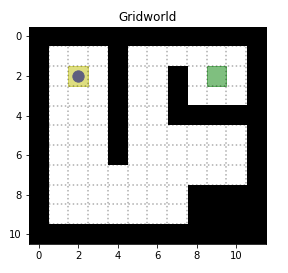


## Ambiente GridWorld

Considere o ambiente ilustrado na figura acima, em que células em preto representam paredes, células em branco indicam estados nos quais um agente (azul) pode se encontrar. O problema consiste em levar o agente de uma posição inicial (amarelo) até uma posição de destino (verde).

## Processo de Decisão de Markov (MDP)

O problema de posicionamento do agente pode ser formulado como um MDP onde:

*   Um estado indica a posição em que o agente se encontra. Ou seja, cada estado é uma posição em branco do ambiente (incluindo a posição inicial, mas exluindo a de destino).
*   O espaço de ações é definido pelas direções de movimento Norte, Sul, Leste e Oeste. A dinâmica do sistema é determinística, de modo que a ação tomada sempre leva o agente à celula vizinha na direção correspondente à ação (com exceção de colisões com paredes, nas quais o agente permanece na mesma célula).
*   As recompensas obtidas são -1 para qualquer par estado-ação, com exceção aos quatro que levam o agente à posição de destino (verde), para os quais a recompensa é 0.
*   O fator de desconto é unitário, de modo que a função valor dos estados indica o valor esperado do número de passos a serem tomados até a posição de destino.

Para este problema, vamos considerar um MDP de horizonte finito, em que o final de um episódio ocorre quando o agente atinge a posição de destino.





## DP: Policy Evaluation

A partir do conhecimento do MDP, podemos avaliar a Função Valor dos Estados associada a uma política qualquer e determinar o retorno esperado por um agente que executa esta política. A figura abaixo ilustra o algoritmo de Policy Evaluation com Atualizações Síncronas.

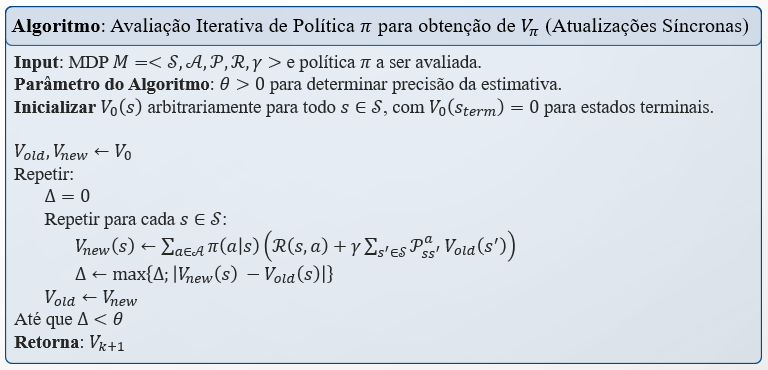

É importante notar que métodos de Programação Dinâmica requerem o conhecimento do modelo do sistema, pois percorrem todos os estados a cada iteração e fazem uso das funções de recompensa e de probabilidades de transição de estados.

## DP: Policy Iteration

Métodos de Policy Iteration implementam, iterativamente, um passo de avaliação de política e um passo de melhoria a partir da função valor obtida. O algoritmo de Policy Evaluation com Atualizações Síncronas visto acima pode ser utilizado no primeiro passo, em conjunto com um segundo passo dado pela melhoria de política baseada no comportamento greedy. A figura abaixo ilustra o algoritmo de Policy Iteration resultante.

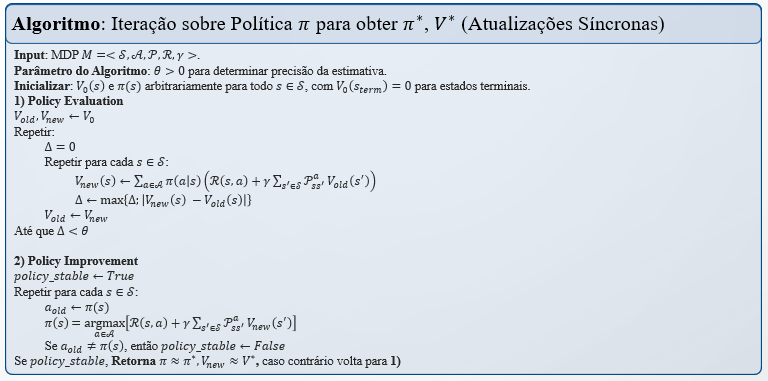

## Tarefas

a) (3 pontos) Implementar função step(s,a) da classe GridWorld que executa dinâmica do sistema e retorna a recompensa obtida, o próximo estado e uma booleana indicando o final do episódio.

b) (4 pontos) Escrever função policy_evaluation(env,policy) que implementa o algoritmo de Avaliação Iterativa de Política com Atualizações Síncronas e retorna a Função Valor V(s) de uma política dada. Qual é a Função Valor dos Estados associada à política aleatória? Em quantos passos espera-se que um agente aleatório chegue na posição de destino a partir da posição inicial?

c) (3 pontos) Escrever função policy_iteration(env) que implementa o algoritmo de iteração sobre política e retorna a Função Valor Ótima V*(s). Qual é a Função Valor dos Estados Ótima para este problema?



## Código


### Imports

Importar bibliotecas necessárias

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
from PIL import Image

### Global Variables

In [2]:
ACTION_SPACE = ['N','S','E','W']
GAMMA = 1

### Funções Auxiliares

####fig2img(fig):
Converte uma figure matplotlib em uma imagem.

In [3]:
#------------------------------------------------------------------------------
# fig2img(fig)
#
# INPUT:
# fig: matplotlib figure object
#
# OUTPUT:
# img: Image of the given figure
#------------------------------------------------------------------------------
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, orientation='landscape')
    buf.seek(0)
    img = Image.open(buf)
    return img

#### get_states_list(env):
Retorna lista de estados a partir de ambiente GridWorld. Função utilizada para gerar enumeração de estados eficiente para algoritmos de Policy Evaluation e Policy Iteration.

A enumeração é gerada na ordem: [0,0], [0,1], ..., [0,11], [1,0], [1,1],..., [1,11], [2,0], [2,1],...
considerando apenas as células do Grid que correspondem a estados (env.matrix [i, j] == 1).

In [4]:
#------------------------------------------------------------------------------
# get_states_list(env)
#
# INPUT:
# env: GridWorld Environment object.
#
# OUTPUT:
# states_list: List of all states (list of numpy arrays with shape=(2,) each)
#------------------------------------------------------------------------------
def get_states_list(env):
  a = np.shape(env.matrix)[0]
  b = np.shape(env.matrix)[1]

  states_list = []

  for i in range(0,a):
    for j in range(0,b):
      if (env.matrix[i,j] == 1 and not np.all(env.end_pos == np.array([i,j]))):
        states_list.append(np.array([i,j]))
      
  
  return states_list

get_state_index(states_list, s): Retorna o indice i do estado s na lista states_list.

In [5]:
def get_state_index(states_list, s):
  n = len(states_list)
  for i in range(0,n):
    if np.all(states_list[i] == s):
      return i

  print('State not found!')
  return -1

#### random_policy(states_list):
Retorna uma política aleatória random_policy (numpy array shape=(n,m), onde n = len(states_list) e m = len(ACTION_SPACE) = 4. Com as probailidades de o agente tomar cada ação em cada estado.

In [6]:
#------------------------------------------------------------------------------
# random_policy(states_list)
#
# INPUT:
# states_list: List of all states.
#
# OUTPUT:
# policy: Random policy given by numpy array with shape=(n,m), n=len(states_list) and m = len(ACTION_SPACE).
#------------------------------------------------------------------------------
def random_policy(states_list):
  n = len(states_list)
  m = len(ACTION_SPACE)
  policy = (1/m)*np.ones((n,m))

  return policy


#### plot_value_function(env,V):
Função que plota Valores dos estados como um colormap sobre o GridWorld. V é um numpy array de shape=(n,), onde n = len(states_list) é o número de estados e env é um objeto da classe GridWorld que representa o ambiente.

In [7]:
#------------------------------------------------------------------------------
# plot_value_function(env, V)
#
# INPUT:
# env: Gridworld object.
# V: Value Function (numpy array with shape=(n,), where n = len(states_list))
#
# OUTPUT:
# img: Image of value function colormap
#------------------------------------------------------------------------------
def plot_value_function(env,V):
  states_list = get_states_list(env)
  n = len(states_list)
  V_grid = np.zeros(np.shape(env.matrix))
  for i in range(0,n):
    s = states_list[i]
    V_grid[s[0]][s[1]] = V[i]
  
  # Plot Gridworld
  m_shape_0 = np.shape(env.matrix)[0]
  m_shape_1 = np.shape(env.matrix)[1]
  fig = plt.figure()
  ax = fig.gca()
  C = ax.imshow(V_grid, interpolation='nearest', cmap='RdYlGn') # Plot Value Function Colormap
  aux = env.matrix
  aux = np.ma.masked_where(aux > 0.5, aux)
  ax.imshow(aux, interpolation='nearest', cmap=cm.Greys_r) # Plot Walls on top
  for i in range(0, m_shape_0):
    ax.plot([-0.5, m_shape_1-0.5], [i-0.5, i-0.5], color='black', alpha=.33, linestyle=':')
  for i in range(0, m_shape_1):
    ax.plot([i-0.5, i-0.5], [-0.5, m_shape_0-0.5], color='black', alpha=.33, linestyle=':')
  ax.add_patch(Rectangle((env.start_pos[1]-0.5, env.start_pos[0]-0.5), 1, 1, fill=True, color='y', alpha=.5))
  ax.add_patch(Rectangle((env.end_pos[1]-0.5, env.end_pos[0]-0.5), 1, 1, fill=True, color='g', alpha=.5))

  fig.colorbar(C, ax=ax) # Add Colorbar
  ax.set_title('GridWorld: Value Function') # Set Title

  img = fig2img(fig)
  plt.close(fig)

  print('Value Function V(s):')
  print(V_grid.astype(int))
        
  return img


#### greedy_improvement(env,V):
Retorna política que segue comportamento greedy a partir de ambiente e função Valor dos Estados V.

In [8]:
#------------------------------------------------------------------------------
# greedy_improvement(env, V)
#
# INPUT:
# env: Gridworld object.
# V: Value Function (numpy array with shape=(n,), where n = len(states_list))
#
# OUTPUT:
# greedy_policy: Greedy policy given by numpy array with shape=(n,m), n=len(states_list) and m = len(ACTION_SPACE).
#------------------------------------------------------------------------------
def greedy_improvement(env,V):
  states_list = get_states_list(env)
  n = len(states_list)
  m = len(ACTION_SPACE)
  greedy_policy = np.zeros((n,m))

  if (n != len(V)):
    print('Error: Conflicting number of states in Value Function and environment!')
    return 0
  
  for state_index in range(0,n):
    s = states_list[state_index]
    q_list = []
    for action_index in range(0,m):
      a = ACTION_SPACE[action_index]
      r, s_next, done = env.step(s,a)
      if (done):
        q_list.append(r)
      else:
        next_state_index = get_state_index(states_list, s_next)
        q_list.append(r + GAMMA*V[next_state_index])
    # Greedy Action
    best_action_index = np.argmax(q_list)
    greedy_policy[state_index, best_action_index] = 1
  
  return greedy_policy


#### check_policy_stable(old_policy, new_policy):
Verifica se políticas antiga e atual são determinísticas e iguais para critério de parada de algoritmo Policy Iteration.

In [9]:
#------------------------------------------------------------------------------
# check_policy_stable(old_policy, new_policy)
#
# INPUT:
# old_policy: Old Policy
# new_policy: New Policy after greedy policy improvement.
#
# OUTPUT:
# stable: Boolean which indicates whether both policies are deterministic and identical
#------------------------------------------------------------------------------
def check_policy_stable(old_policy, new_policy):

  if ((np.shape(old_policy)[0] != np.shape(new_policy)[0]) or \
      (np.shape(old_policy)[1] != np.shape(new_policy)[1])):
    print('ERROR: Conflicting array dimensions for new and old policies!')
    return False
  
  n = np.shape(old_policy)[0]
  m = np.shape(old_policy)[1]

  # Check if policies are deterministic
  deterministic = True
  for i in range(0,n):
    for j in range(0,m):
      if ((old_policy[i][j]!=1 and old_policy[i][j]!=0) or \
          (new_policy[i][j]!=1 and new_policy[i][j]!=0)):
        deterministic = False
        break
  
  if (not deterministic):
    # Policies are not both deterministic!
    return False
  
  # Check if policies are identical
  if np.all(old_policy == new_policy):
    return True
  else:
    return False


### Tarefa a) Classe GridWorld

Implementar a função step(self, state, action), que recebe o estado atual do agente e a ação tomada e retorna a recompensa obtida, o estado seguinte e uma variável booleana que indica o final do episódio.

As posições do agente são codificadas na matriz do ambiente de acordo com a figua abaixo.

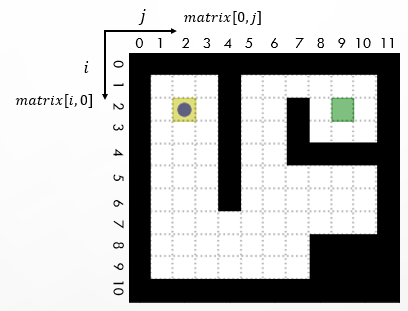

In [10]:
# CLASSES ---------------------------------------------------------------------
#--------------------------------------------
# GridWorld
# PROPERTIES:
# matrix: 2D Numpy array representing grid (1: Path, 0: Wall)
# start_pos: GridWorld starting position (1D numpy array with shape=(2,) or list)
# end_pos: GridWorld end position (1D numpy array with shape=(2,) or list)
#
#
# METHODS:
# __init__: Class default constructor
# show(self, state): Show the Grid on given state
# step(self, state, action): Perform Environment Dynamics step given state and action
class GridWorld:
    def __init__(self, matrix, start_pos, end_pos):
        self.matrix = matrix
        self.start_pos = start_pos
        self.end_pos = end_pos
        
    #------------------------------------------------------------------------------
    # show(self, state, t=None, open_figure=False)
    #
    # INPUT:
    # state: Current agent position (1D numpy array with shape=(2,) or list)
    # open_figure: Whether to open the matplotlib figure or just return as image
    # t: Timestep (int)
    # open_figure: Indicates whether to open matplotlib figure or just save img (Bool)
    #
    # OUTPUT:
    # img: Image of the Environment
    #------------------------------------------------------------------------------
    def show(self, state, t=None, open_figure=False):
        m_shape_0 = np.shape(self.matrix)[0]
        m_shape_1 = np.shape(self.matrix)[1]
        fig = plt.figure()
        ax = fig.gca()
        # Plot Gridworld
        ax.imshow(self.matrix, interpolation='nearest', cmap=cm.Greys_r)
        for i in range(0, m_shape_0):
          ax.plot([-0.5, m_shape_1-0.5], [i-0.5, i-0.5], color='black', alpha=.33, linestyle=':')
        for i in range(0, m_shape_1):
          ax.plot([i-0.5, i-0.5], [-0.5, m_shape_0-0.5], color='black', alpha=.33, linestyle=':')
        ax.add_patch(Rectangle((self.start_pos[1]-0.5, self.start_pos[0]-0.5), 1, 1, fill=True, color='y', alpha=.5))
        ax.add_patch(Rectangle((self.end_pos[1]-0.5, self.end_pos[0]-0.5), 1, 1, fill=True, color='g', alpha=.5))

        # Plot Agent
        ax.scatter(state[1], state[0], s=128, color='b')
        if (t):
            title_str = 'Gridworld: t = ' + str(t)
        else:
            title_str = 'Gridworld'
        ax.set_title(title_str)
        
        img = fig2img(fig)
        if (open_figure==False):
            plt.close(fig)
        
        return img
        
        
    
    #------------------------------------------------------------------------------
    # step(self, state, action)
    #
    # INPUT:
    # state: Current agent position (1D numpy array with shape=(2,))
    # action: Action taken ('N': North, 'S': South, 'E': East, 'W': West)
    #
    # OUTPUT:
    # reward: Immediate Reward obtained (float)
    # next_state: Next agent position (1D numpy array with shape=(2,))
    # done: True if episode ended, False otherwise (bool)
    #------------------------------------------------------------------------------
    def step(self, state, action):

      # Escreva a dinâmica de transição de estados aqui:
      def _get_next_state(available_states, next_pos, state):
        if get_state_index(available_states, next_pos) != -1:
          return next_pos
        return state

      available_states = get_states_list(self)
      available_states.append(self.end_pos)

      # a = 'N': North
      if action == 'N':
        next_pos = np.array([state[0] - 1, state[1]])

      # a = 'S': South
      elif action == 'S':
        next_pos = np.array([state[0] + 1, state[1]])

      # a = 'E': East
      elif action == 'E':
        next_pos = np.array([state[0], state[1] + 1])
      
      # a = 'W': West
      elif action == 'W':
        next_pos = np.array([state[0], state[1] - 1])

      next_state = _get_next_state(available_states, next_pos, state)

      # Reward
      done = False
      if (next_state[0] == self.end_pos[0] and next_state[1] == self.end_pos[1]):
          reward = 0
          done = True
      else:
          reward = -1

      return reward, next_state, done
   

### Criação do Ambiente

In [11]:
# Initialize GridWorld Matrix and Start/End Positions
grid_matrix = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\
                        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],\
                        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0],\
                        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0],\
                        [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],\
                        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],\
                        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],\
                        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],\
                        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],\
                        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],\
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
start_pos = np.array([2,2])
end_pos = np.array([2,9])

In [12]:
# Create GridWorld Environment
env = GridWorld(grid_matrix, start_pos, end_pos)


Vamos visualizar o estado inicial do ambiente

Initial State


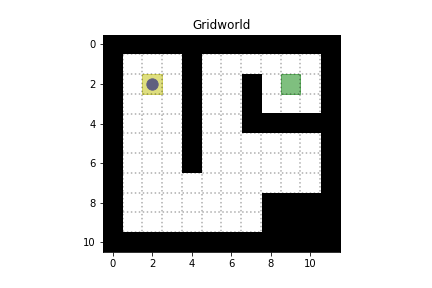

In [13]:
# Visualize initial state
print('Initial State')
env.show(start_pos)

Teste aqui a função env.step(s,a). Vamos considerar os seguintes pares estado-ação:


*   s = np.array([2,2]), a = 'S' ---> r = -1, s' = np.array([3,2]), done = False
*   s = np.array([1,1]), a = 'N' ---> r = -1, s' = np.array([1,1]), done = False
*   s = np.array([2,8]), a = 'E' ---> r = 0, s' = np.array([2,9]), done = True



In [14]:
# Test Case 1:
s = np.array([2,2])
a = 'S'
r, s_next, done = env.step(s,a)
print('--------------------')
print('State = ' + str(s))
print('Action = ' + str(a))
print('Reward = ' + str(r))
print('Next State = ' + str(s_next))
print('Done = ' + str(done))

# Test Case 2:
s = np.array([1,1])
a = 'N'
r, s_next, done = env.step(s,a)
print('--------------------')
print('State = ' + str(s))
print('Action = ' + str(a))
print('Reward = ' + str(r))
print('Next State = ' + str(s_next))
print('Done = ' + str(done))

# Test Case 3:
s = np.array([2,8])
a = 'E'
r, s_next, done = env.step(s,a)
print('--------------------')
print('State = ' + str(s))
print('Action = ' + str(a))
print('Reward = ' + str(r))
print('Next State = ' + str(s_next))
print('Done = ' + str(done))

--------------------
State = [2 2]
Action = S
Reward = -1
Next State = [3 2]
Done = False
State not found!
--------------------
State = [1 1]
Action = N
Reward = -1
Next State = [1 1]
Done = False
--------------------
State = [2 8]
Action = E
Reward = 0
Next State = [2 9]
Done = True


### Criação de Lista de Estados e Política Aleatória

In [15]:
# States List
states_list = get_states_list(env)
print(states_list)

[array([1, 1]), array([1, 2]), array([1, 3]), array([1, 5]), array([1, 6]), array([1, 7]), array([1, 8]), array([1, 9]), array([ 1, 10]), array([2, 1]), array([2, 2]), array([2, 3]), array([2, 5]), array([2, 6]), array([2, 8]), array([ 2, 10]), array([3, 1]), array([3, 2]), array([3, 3]), array([3, 5]), array([3, 6]), array([3, 8]), array([3, 9]), array([ 3, 10]), array([4, 1]), array([4, 2]), array([4, 3]), array([4, 5]), array([4, 6]), array([5, 1]), array([5, 2]), array([5, 3]), array([5, 5]), array([5, 6]), array([5, 7]), array([5, 8]), array([5, 9]), array([ 5, 10]), array([6, 1]), array([6, 2]), array([6, 3]), array([6, 5]), array([6, 6]), array([6, 7]), array([6, 8]), array([6, 9]), array([ 6, 10]), array([7, 1]), array([7, 2]), array([7, 3]), array([7, 4]), array([7, 5]), array([7, 6]), array([7, 7]), array([7, 8]), array([7, 9]), array([ 7, 10]), array([8, 1]), array([8, 2]), array([8, 3]), array([8, 4]), array([8, 5]), array([8, 6]), array([8, 7]), array([9, 1]), array([9, 2]

In [16]:
len(states_list)

71

In [17]:
# Initialize random policy
rand_pi = random_policy(states_list)

### Tarefa b) Policy Evaluation

Implementar a função policy_evaluation(env,policy) que recebe o ambiente e a política a se avaliada e retorna a Função Valor dos Estados.

Note que a política é dada por um numpy array de shape=(n,m), onde n = len(states_list) e m = len(ACTION_SPACE) = 4. Assim:
- policy[k, 0] = probabilidade de tomar ação 'N' no estado states_list[k].
- policy[k, 1] = probabilidade de tomar ação 'S' no estado states_list[k].
- policy[k, 2] = probabilidade de tomar ação 'E' no estado states_list[k].
- policy[k, 3] = probabilidade de tomar ação 'W' no estado states_list[k].

A variável retornada deve ser um numpy array de shape=(n,) com os valores de cada estado na ordem da enumeração.

Sugestão: Utilizar duas variáveis (V_old e V_new) e atualizar todos valores de V_new com base nos valores de V_old a cada passo (Atualizações síncronas). Note que a atualização de Bellman não requer o cálculo do somatório interno, uma vez que a dinâmica do ambiente é determinística (dado o estado e a ação tomada, o estado seguinte é conhecido)

In [18]:
#------------------------------------------------------------------------------
# policy_evaluation(env,policy,theta)
#
# INPUT:
# env: GridWorld Environment object.
# policy: Policy given by numpy array with shape=(n,m), n = len(states_list) and m = len(ACTION_SPACE).
#         policy[k,0] probability of taking action 'N' in state states_list[k]
#         policy[k,1] probability of taking action 'S' in state states_list[k]
#         policy[k,2] probability of taking action 'E' in state states_list[k]
#         policy[k,3] probability of taking action 'W' in state states_list[k]
#
#         note that policy[k,0]+policy[k,1]+policy[k,2]+policy[k,3] = 1,
#         for any k corresponding to a state.
# theta: Parameter used to control precision of value function estimate (float, >0).
#        (If the maximum absolute difference between the values of a state on subsequent iterations
#        is smaller than theta, then stop).
#
# OUTPUT:
# V_pi: Value Function given policy (numpy array with shape=(n,)) with State Values in corresponding cells.
#------------------------------------------------------------------------------
def policy_evaluation(env,policy,theta):
  n = len(states_list)
  m = len(ACTION_SPACE)

  V_old = np.zeros(n)

  stop = False
  k = 0
  while stop == False:
    print('k = ' + str(k))
    delta = 0
    V_pi = np.zeros(n)

    for s_index in range(0,n):
      state = states_list[s_index]
      new_v = 0

      for action_index in range(0,m):
        reward, next_state, done = env.step(state, ACTION_SPACE[action_index])
        
        if done:
          new_v = new_v + policy[s_index][action_index]*\
            (reward + GAMMA*0)
        else:
          next_state_index = get_state_index(states_list, next_state)
          new_v = new_v + policy[s_index][action_index]*\
            (reward + GAMMA*V_old[next_state_index])
        
      V_pi[s_index] = new_v
      delta = max([delta, abs(V_pi[s_index] - V_old[s_index])])

    V_old = np.copy(V_pi)
    k = k+1

    if (delta < theta):
      stop = True

  return V_pi

  

Vamos testar a função policy_evaluation(env,policy,theta=0.1) com a política aleatória.

In [19]:
V_rand = policy_evaluation(env,rand_pi,0.1)

k = 0
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State no

State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
k = 8
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State no

State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
k = 16
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State n

State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
k = 25
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State n

State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
k = 33
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State n

State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
k = 42
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State n

State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
k = 50
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State n

State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
k = 58
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State n

State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
k = 66
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State n

KeyboardInterrupt: 

In [ ]:
# Visualize Value Function
plot_value_function(env,V_rand)

### Tarefa c) Policy Iteration

Implementar a função policy_iteration(env, theta) que faz uso das funções policy_evaluation(env,policy, theta) e greedy_improvement(env, V) para executar algoritmo de iteração de política. A função deve retornar a política ótima $\pi^*$ e a função valor ótima $V^*$.

Sugestão Fazer uso das funções:
*   random_policy(states_list) para criação de política aleatória inicial
*   policy_evaluation(env,pi,theta) implementada na tarefa b) para avaliação da política $\pi$
*   greedy_improvement(env, V) para obter política de comportamento greedy sobre função Valor V
*   check_policy_stable(old_policy, new_policy) para verificar critério de parada do algoritmo.

In [ ]:
#------------------------------------------------------------------------------
# policy_iteration(env,theta)
#
# INPUT:
# env: GridWorld Environment object.
# theta: Parameter used to control precision of value function estimate (float, >0).
#        (If the maximum absolute difference between the values of a state on subsequent iterations
#        is smaller than theta, then stop).
#
# OUTPUT:
# pi: Optimal Policy (numpy array with shape=(n,m)), n = len(states_list) and m = len(ACTION_SPACE).
# V_pi: Optimal Value Function (numpy array with shape=(n,))
#------------------------------------------------------------------------------
def policy_iteration(env, theta):
  n = len(states_list)
  m = len(ACTION_SPACE)

  old_pi = (1/m)*np.ones((n,m))
  pi = np.copy(old_pi)

  policy_stable = False
  cont = 0
  while(not policy_stable):
    cont += 1
    print(cont)

    print('Policy Evaluation')
    V_pi = policy_evaluation(env, old_pi, theta)

    print('Policy Improvement')
    pi = greedy_improvement(env, V_pi)

    policy_stable = check_policy_stable(old_pi, pi)

    old_pi = np.copy(pi)

  return pi, V_pi
  

Chamar a função policy_iteration com o parâmetro theta=0.1 e plotar política ótima $\pi^*$ e função valor e ótima $V^*(s)$ obtidas:

In [ ]:
pi, V = policy_iteration(env, 0.1)

A saída de streaming foi truncada nas últimas 5000 linhas.
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
k = 3405
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not found!
State not foun

Value Function V(s):
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 -20 -19 -18   0  -4  -3  -2  -1   0  -1   0]
 [  0 -19 -18 -17   0  -5  -4   0   0   0   0   0]
 [  0 -18 -17 -16   0  -6  -5   0  -1   0  -1   0]
 [  0 -17 -16 -15   0  -7  -6   0   0   0   0   0]
 [  0 -16 -15 -14   0  -8  -7  -8  -9 -10 -11   0]
 [  0 -15 -14 -13   0  -9  -8  -9 -10 -11 -12   0]
 [  0 -14 -13 -12 -11 -10  -9 -10 -11 -12 -13   0]
 [  0 -15 -14 -13 -12 -11 -10 -11   0   0   0   0]
 [  0 -16 -15 -14 -13 -12 -11 -12   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


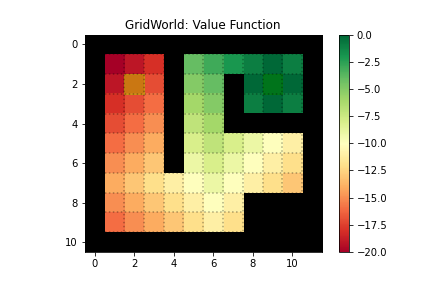

In [ ]:
# Plot Optimal Value Function
plot_value_function(env,V)